In [1]:
# Imports simples
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pickle

print("✅ Imports OK")

✅ Imports OK


## 1. Charger les données augmentées

In [2]:
# Charger le fichier avec 3,248 observations
df = pd.read_csv('../data/processed/merged_dataset.csv')
df['date_capteur'] = pd.to_datetime(df['date_capteur'])

print(f"✅ Données chargées: {len(df):,} observations")
print(f"   Stations: {df['station_id'].nunique()}")
print(f"   Période: {df['date_capteur'].min().date()} → {df['date_capteur'].max().date()}")
print(f"\nColonnes disponibles:")
print(df.columns.tolist())

✅ Données chargées: 3,248 observations
   Stations: 69
   Période: 2015-10-12 → 2018-12-24

Colonnes disponibles:
['date_capteur', 'date_satellite', 'days_diff', 'station_id', 'latitude', 'longitude', 'pH', 'oxygene_dissous', 'COD', 'CODMn', 'NH4N', 'TPH', 'DIP', 'DIN', 'quality_score', 'NDWI', 'chlorophyll_index', 'turbidity_index', 'is_interpolated']


## 2. Sélectionner les features pour le modèle

In [3]:
# Features capteurs (mesures au sol)
features_capteurs = [
    'pH',
    'oxygene_dissous',
    'COD',
    'CODMn',
    'NH4N',
    'TPH',
    'DIP',
    'DIN'
]

# Features satellites (images)
features_satellites = [
    'NDWI',
    'chlorophyll_index',
    'turbidity_index'
]

# Target (ce qu'on veut prédire)
target = 'quality_score'  # Score de qualité eau (0-10)

# Toutes les features
all_features = features_capteurs + features_satellites

print(f"✅ Features sélectionnées: {len(all_features)}")
print(f"   Capteurs: {len(features_capteurs)}")
print(f"   Satellites: {len(features_satellites)}")
print(f"   Target: {target}")

✅ Features sélectionnées: 11
   Capteurs: 8
   Satellites: 3
   Target: quality_score


## 3. Normalisation (mettre entre 0 et 1)

**Pourquoi?** Les réseaux neurones apprennent mieux avec des valeurs entre 0 et 1

In [4]:
# Créer le scaler (normalisateur)
scaler_features = MinMaxScaler()  # Pour les features
scaler_target = MinMaxScaler()    # Pour le target

# Normaliser les features (X)
X = df[all_features].values
X_normalized = scaler_features.fit_transform(X)

# Normaliser le target (y)
y = df[[target]].values
y_normalized = scaler_target.fit_transform(y)

print("✅ Normalisation terminée")
print(f"\nAvant normalisation:")
print(f"   pH min: {df['pH'].min():.2f}, max: {df['pH'].max():.2f}")
print(f"   NDWI min: {df['NDWI'].min():.2f}, max: {df['NDWI'].max():.2f}")
print(f"\nAprès normalisation:")
print(f"   Min: {X_normalized.min():.2f}, Max: {X_normalized.max():.2f}")
print(f"   Target min: {y_normalized.min():.2f}, max: {y_normalized.max():.2f}")

✅ Normalisation terminée

Avant normalisation:
   pH min: 6.30, max: 8.90
   NDWI min: -0.76, max: 1.00

Après normalisation:
   Min: 0.00, Max: 1.00
   Target min: 0.00, max: 1.00


## 4. Créer séquences temporelles

**Concept:** Le modèle va regarder 14 jours d'historique pour prédire le jour suivant

**Exemple:**
- Input: Jour 1 → Jour 14 (14 mesures)
- Output: Qualité du jour 15 (1 valeur)

In [5]:
def create_sequences(X, y, station_ids, sequence_length=14):
    """
    Créer séquences temporelles par station
    
    Args:
        X: Features normalisées (3248, 11)
        y: Target normalisé (3248, 1)
        station_ids: IDs des stations
        sequence_length: Longueur historique (14 jours)
    
    Returns:
        X_sequences: (n_sequences, 14, 11)
        y_sequences: (n_sequences, 1)
    """
    X_sequences = []
    y_sequences = []
    
    # Pour chaque station séparément
    for station_id in np.unique(station_ids):
        # Données de cette station
        mask = station_ids == station_id
        X_station = X[mask]
        y_station = y[mask]
        
        # Créer séquences glissantes
        # Si on a 50 jours, on peut créer 50-14 = 36 séquences
        for i in range(len(X_station) - sequence_length):
            # Input: 14 jours d'historique
            X_seq = X_station[i:i+sequence_length]
            # Output: qualité du jour suivant
            y_seq = y_station[i+sequence_length]
            
            X_sequences.append(X_seq)
            y_sequences.append(y_seq)
    
    return np.array(X_sequences), np.array(y_sequences)

# Créer les séquences
print("Création séquences temporelles...")
X_seq, y_seq = create_sequences(
    X_normalized, 
    y_normalized, 
    df['station_id'].values,
    sequence_length=14
)

print(f"\n✅ Séquences créées:")
print(f"   Nombre total: {len(X_seq):,}")
print(f"   Shape X: {X_seq.shape}  (sequences, timesteps, features)")
print(f"   Shape y: {y_seq.shape}  (sequences, 1)")
print(f"\n   Exemple: {len(X_seq)} séquences de 14 jours avec 11 features chacune")

Création séquences temporelles...

✅ Séquences créées:
   Nombre total: 2,471
   Shape X: (2471, 14, 11)  (sequences, timesteps, features)
   Shape y: (2471, 1)  (sequences, 1)

   Exemple: 2471 séquences de 14 jours avec 11 features chacune


## 5. Split Train/Validation/Test

**Division:**
- Train (70%) : Pour apprendre
- Validation (15%) : Pour ajuster hyperparamètres
- Test (15%) : Pour évaluer performance finale

In [6]:
# Mélanger aléatoirement (important!)
indices = np.arange(len(X_seq))
np.random.seed(42)  # Pour reproductibilité
np.random.shuffle(indices)

X_seq = X_seq[indices]
y_seq = y_seq[indices]

# Calculer les tailles
n_samples = len(X_seq)
n_train = int(0.70 * n_samples)  # 70%
n_val = int(0.15 * n_samples)    # 15%
n_test = n_samples - n_train - n_val  # Le reste (≈15%)

# Diviser
X_train = X_seq[:n_train]
y_train = y_seq[:n_train]

X_val = X_seq[n_train:n_train+n_val]
y_val = y_seq[n_train:n_train+n_val]

X_test = X_seq[n_train+n_val:]
y_test = y_seq[n_train+n_val:]

print("✅ Division effectuée:")
print(f"\n   Train: {len(X_train):,} séquences ({len(X_train)/len(X_seq)*100:.1f}%)")
print(f"   Val:   {len(X_val):,} séquences ({len(X_val)/len(X_seq)*100:.1f}%)")
print(f"   Test:  {len(X_test):,} séquences ({len(X_test)/len(X_seq)*100:.1f}%)")
print(f"\n   Total: {len(X_seq):,} séquences")

✅ Division effectuée:

   Train: 1,729 séquences (70.0%)
   Val:   370 séquences (15.0%)
   Test:  372 séquences (15.1%)

   Total: 2,471 séquences


## 6. Visualisation distribution

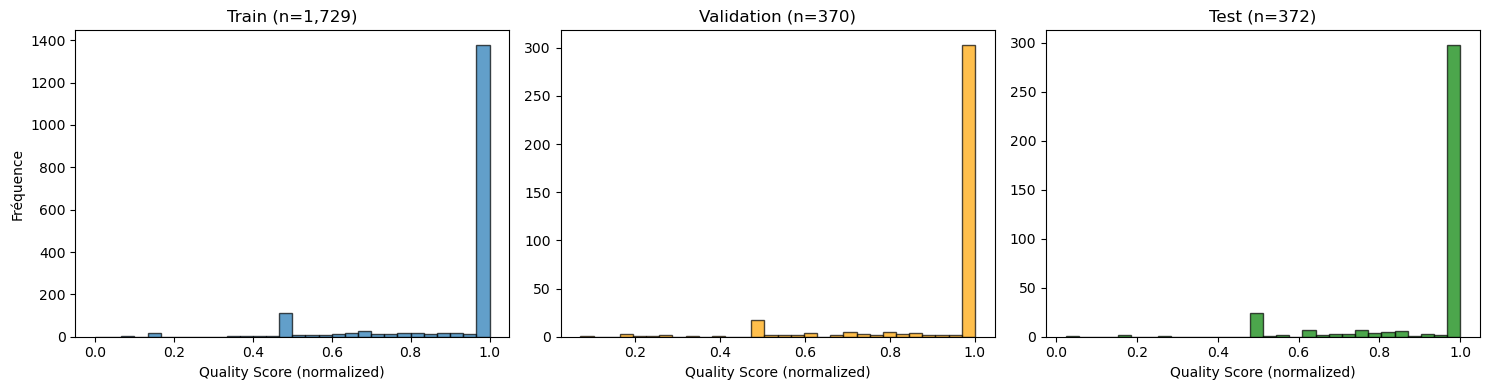

✅ Distribution similaire entre train/val/test (bon signe!)


In [7]:
# Visualiser distribution du target
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(y_train.flatten(), bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title(f'Train (n={len(y_train):,})')
axes[0].set_xlabel('Quality Score (normalized)')
axes[0].set_ylabel('Fréquence')

axes[1].hist(y_val.flatten(), bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title(f'Validation (n={len(y_val):,})')
axes[1].set_xlabel('Quality Score (normalized)')

axes[2].hist(y_test.flatten(), bins=30, edgecolor='black', alpha=0.7, color='green')
axes[2].set_title(f'Test (n={len(y_test):,})')
axes[2].set_xlabel('Quality Score (normalized)')

plt.tight_layout()
plt.show()

print("✅ Distribution similaire entre train/val/test (bon signe!)")

## 7. Sauvegarder pour entraînement

In [8]:
import os

# Créer dossier si nécessaire
os.makedirs('../data/processed/sequences', exist_ok=True)

# Sauvegarder les séquences
np.savez_compressed(
    '../data/processed/sequences/train.npz',
    X=X_train,
    y=y_train
)

np.savez_compressed(
    '../data/processed/sequences/val.npz',
    X=X_val,
    y=y_val
)

np.savez_compressed(
    '../data/processed/sequences/test.npz',
    X=X_test,
    y=y_test
)

# Sauvegarder les scalers (pour dénormaliser les prédictions plus tard)
with open('../data/processed/sequences/scaler_features.pkl', 'wb') as f:
    pickle.dump(scaler_features, f)

with open('../data/processed/sequences/scaler_target.pkl', 'wb') as f:
    pickle.dump(scaler_target, f)

print("💾 Fichiers sauvegardés:")
print("   data/processed/sequences/train.npz")
print("   data/processed/sequences/val.npz")
print("   data/processed/sequences/test.npz")
print("   data/processed/sequences/scaler_features.pkl")
print("   data/processed/sequences/scaler_target.pkl")

💾 Fichiers sauvegardés:
   data/processed/sequences/train.npz
   data/processed/sequences/val.npz
   data/processed/sequences/test.npz
   data/processed/sequences/scaler_features.pkl
   data/processed/sequences/scaler_target.pkl


## 8. Résumé final

In [9]:
print("="*70)
print("✅ PRÉPARATION TERMINÉE")
print("="*70)

print(f"\n📊 DONNÉES:")
print(f"   Observations initiales: {len(df):,}")
print(f"   Séquences créées: {len(X_seq):,}")
print(f"   Longueur séquence: 14 jours")
print(f"   Features: {len(all_features)}")

print(f"\n📦 SPLITS:")
print(f"   Train: {len(X_train):,} ({len(X_train)/len(X_seq)*100:.1f}%)")
print(f"   Val:   {len(X_val):,} ({len(X_val)/len(X_seq)*100:.1f}%)")
print(f"   Test:  {len(X_test):,} ({len(X_test)/len(X_seq)*100:.1f}%)")

print(f"\n🎯 SHAPES:")
print(f"   X_train: {X_train.shape}  (batch, sequence, features)")
print(f"   y_train: {y_train.shape}  (batch, 1)")

print(f"\n💾 FICHIERS:")
print(f"   ✅ train.npz")
print(f"   ✅ val.npz")
print(f"   ✅ test.npz")
print(f"   ✅ scalers.pkl")

print(f"\n🚀 PROCHAINE ÉTAPE:")
print(f"   Créer et entraîner le modèle ConvLSTM!")
print(f"   Notebook: 05_entrainement_modele.ipynb")

print("\n" + "="*70)

✅ PRÉPARATION TERMINÉE

📊 DONNÉES:
   Observations initiales: 3,248
   Séquences créées: 2,471
   Longueur séquence: 14 jours
   Features: 11

📦 SPLITS:
   Train: 1,729 (70.0%)
   Val:   370 (15.0%)
   Test:  372 (15.1%)

🎯 SHAPES:
   X_train: (1729, 14, 11)  (batch, sequence, features)
   y_train: (1729, 1)  (batch, 1)

💾 FICHIERS:
   ✅ train.npz
   ✅ val.npz
   ✅ test.npz
   ✅ scalers.pkl

🚀 PROCHAINE ÉTAPE:
   Créer et entraîner le modèle ConvLSTM!
   Notebook: 05_entrainement_modele.ipynb

